<a href="https://colab.research.google.com/github/QiaoLin22/MASTER-LLM-DL/blob/main/Transformers_from_Scratch(GPT_enhanced).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Setup
```
Help me to create a transformer for predicting the next day's temperature, given an input sequence of the temperature on 32 prior days.

*Transformer architecture*
- We are are going to use a traditional transformer architecture with attention and MLP.
- Make sure to include skip connections + norms (probably pre-layer norm, as that has been found to be better than the original transformer).
- We are are going to use 8 layers of attention plus MLP (let's go up to a dimension of 256 within the MLP).

Other notes:
- The goal of the transformer is next token prediction, so make sure the labels/targets are the inputs shifted by one.
- Make sure to include train and validation datasets, and evaluate the validation set loss at the end of each epoch.
- Let's include gradient accumulation for training of 2.
-

* Embeddings *
- Each input will be a temperature (i.e. a scaler) in Celsius.
- The embedding dimension should be 64.
- Our input length is 32, and we need to add positional information to each input and embedding, and let's use sinusoidal embeddings as an approach.

* Data *
- Let's start off with a training batch size of 4 and a validation batch size of 4.
- Data needs to be of 32 input length, of temperatures.
- Provide 1024 rows of dummy data and split that 80:20 into data for training and validation.  You can initialise some random temperatures within a reasonable range for Ireland.

Pick reasonable values for the model config where I did not give enough detail.

Now, give me some code to a) instantiate the model, b) to run a forward pass, c) to run a simple training loop (include some dummy data for a short training).

BTW, I'll run this on a GPU so we'll want to move everything to CUDA where appropriate.
```

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Function to generate dummy temperature data
def generate_dummy_data(num_samples=1024, seq_length=32):
    # Generating data within a typical temperature range for Ireland
    temperatures = np.random.uniform(low=0.0, high=20.0, size=(num_samples, seq_length))
    # Creating targets: next day temperature, i.e., first temperature of the next sequence
    targets = np.roll(temperatures, -1, axis=1)[:, -1]
    return temperatures, targets

temperatures, targets = generate_dummy_data()
# Splitting the data into training and validation sets
train_data = TensorDataset(torch.Tensor(temperatures[:int(0.8 * len(temperatures))]), torch.Tensor(targets[:int(0.8 * len(targets))]))
val_data = TensorDataset(torch.Tensor(temperatures[int(0.8 * len(temperatures)):]), torch.Tensor(targets[int(0.8 * len(targets)):]))

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

In [6]:
print(train_data[818])

(tensor([ 1.7124, 18.1672,  7.5684,  0.7304, 10.7609,  8.9831, 19.2710,  6.7774,
         2.9369, 14.2212, 13.4108,  4.2812, 12.3639, 11.7204,  3.2645,  8.8956,
         8.9779,  2.9561,  0.9075, 13.0888,  0.5770, 16.7576, 15.8696, 16.4456,
        19.8240,  3.7562, 19.4460, 17.4040, 13.8916, 14.3930, 10.5411,  9.2621]), tensor(1.7124))


In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape[0] is batch size, x.shape[1] is sequence length
        x = x + self.pe[:x.shape[1], :].unsqueeze(0)  # Extend for batch size
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, max_len=32):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Define the transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=0.1,
            activation='relu',  # Include ReLU activation in the MLP
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        self.decoder = nn.Linear(d_model, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Decoding from the last token for prediction
        return output

model = TransformerModel(input_dim=1, d_model=64, nhead=8, num_encoder_layers=8, dim_feedforward=256).cuda()


In [8]:
# Run model.forward
import torch

# Define input parameters
batch_size = 1  # Number of sequences in the batch
seq_length = 32  # Length of each sequence
input_dim = 1  # Dimensionality of input features

# Create a batch of input sequences filled with ones
input_sequences = torch.ones((batch_size, seq_length, input_dim)).cuda()

# Run the model's forward pass
output = model(input_sequences)

# Print the output
print(output.item())

-1.9681894779205322


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

def train_loop(model, train_loader, val_loader, optimizer, epochs):
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    step_losses = []
    val_steps = []  # To record the steps at which validation is performed
    steps_per_epoch = len(train_loader)

    # Ensure val_interval is at least 1
    val_interval = max(steps_per_epoch // 4, 1)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        num_batches = 0

        for i, (data, targets) in enumerate(train_loader):
            data, targets = data.cuda(), targets.cuda()
            optimizer.zero_grad()

            outputs = model(data.unsqueeze(-1))  # Ensure input is 3D
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_batches += 1

            # Print training loss every step
            print(f'Epoch {epoch+1}, Step {i+1}/{steps_per_epoch}, Training Loss: {loss.item()}')

            step_losses.append(loss.item())

            # Calculate validation loss every quarter epoch
            if (i + 1) % val_interval == 0 or (i + 1) == steps_per_epoch:
                model.eval()
                total_val_loss = 0
                num_val_batches = 0
                with torch.no_grad():
                    for data, targets in val_loader:
                        data, targets = data.cuda(), targets.cuda()
                        outputs = model(data.unsqueeze(-1))
                        val_loss = criterion(outputs.squeeze(), targets)
                        total_val_loss += val_loss.item()
                        num_val_batches += 1

                average_val_loss = total_val_loss / num_val_batches
                val_losses.append(average_val_loss)
                val_steps.append(len(step_losses))  # Record the step at which validation is performed
                print(f'Epoch {epoch+1}, Step {i+1}/{steps_per_epoch}, Validation Loss: {average_val_loss}')
                model.train()

        average_train_loss = total_train_loss / num_batches
        train_losses.append(average_train_loss)
        print(f'Epoch {epoch+1}, Training Loss: {average_train_loss}')

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(step_losses)), step_losses, label='Training Loss per Step', linestyle='-', marker='o')
    plt.scatter(val_steps, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Assuming you have your model, train_loader, and val_loader defined
optimizer = optim.AdamW(model.parameters(), lr=0.001)


Epoch 1, Step 1/205, Training Loss: 271.1694641113281
Epoch 1, Step 2/205, Training Loss: 33.74992370605469
Epoch 1, Step 3/205, Training Loss: 51.304542541503906
Epoch 1, Step 4/205, Training Loss: 28.801753997802734
Epoch 1, Step 5/205, Training Loss: 25.008068084716797
Epoch 1, Step 6/205, Training Loss: 63.76789855957031
Epoch 1, Step 7/205, Training Loss: 8.344295501708984
Epoch 1, Step 8/205, Training Loss: 21.045074462890625
Epoch 1, Step 9/205, Training Loss: 49.88588333129883
Epoch 1, Step 10/205, Training Loss: 21.30544090270996
Epoch 1, Step 11/205, Training Loss: 22.13054656982422
Epoch 1, Step 12/205, Training Loss: 65.8195571899414
Epoch 1, Step 13/205, Training Loss: 29.4724178314209
Epoch 1, Step 14/205, Training Loss: 26.84172248840332
Epoch 1, Step 15/205, Training Loss: 50.03721618652344
Epoch 1, Step 16/205, Training Loss: 87.72686004638672
Epoch 1, Step 17/205, Training Loss: 94.4818344116211
Epoch 1, Step 18/205, Training Loss: 16.83833122253418
Epoch 1, Step 19/2

Epoch 1, Step 51/205, Validation Loss: 32.55419554618689
Epoch 1, Step 52/205, Training Loss: 28.903657913208008
Epoch 1, Step 53/205, Training Loss: 29.22235679626465
Epoch 1, Step 54/205, Training Loss: 37.875770568847656
Epoch 1, Step 55/205, Training Loss: 7.695070266723633
Epoch 1, Step 56/205, Training Loss: 32.946468353271484
Epoch 1, Step 57/205, Training Loss: 46.33344268798828
Epoch 1, Step 58/205, Training Loss: 30.340742111206055
Epoch 1, Step 59/205, Training Loss: 46.417503356933594
Epoch 1, Step 60/205, Training Loss: 35.819454193115234
Epoch 1, Step 61/205, Training Loss: 32.457122802734375
Epoch 1, Step 62/205, Training Loss: 37.530452728271484
Epoch 1, Step 63/205, Training Loss: 23.18960189819336
Epoch 1, Step 64/205, Training Loss: 73.13516235351562
Epoch 1, Step 65/205, Training Loss: 28.182025909423828
Epoch 1, Step 66/205, Training Loss: 27.73003387451172
Epoch 1, Step 67/205, Training Loss: 34.75462341308594
Epoch 1, Step 68/205, Training Loss: 49.83690643310547

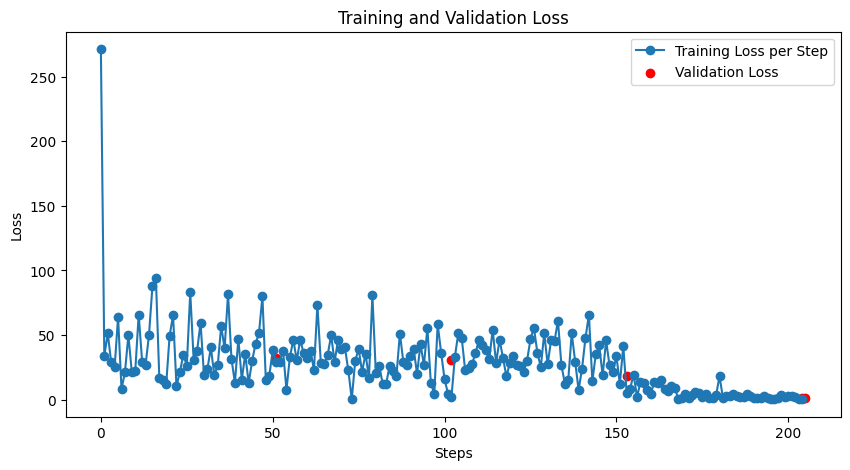

In [10]:
train_loop(model, train_loader, val_loader, optimizer, 1)

## Weather in Tokyo

In [11]:
!pip install meteostat -q -U

In [12]:
from datetime import datetime
from meteostat import Point, Daily

# Set time period
start = datetime(2000, 1, 1)
end = datetime(2024, 5, 1)

# Create a Point for Tokyo
tokyo = Point(35.6528, 139.8394)

# Get daily data
data = Daily(tokyo, start, end)
data = data.fetch()

# Print the data
print(data)

# maybe do some data checks or cleaning.

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2000-01-01   8.2   6.1  12.6   NaN   NaN  346.0  15.6   NaN  1020.4   NaN
2000-01-02   7.2   4.1   8.8   NaN   NaN   55.0   8.1   NaN  1020.1   NaN
2000-01-03   9.9   4.0  16.5   NaN   NaN  328.0   9.2   NaN  1011.0   NaN
2000-01-04   9.4   7.5  14.0   NaN   NaN  330.0  16.5   NaN  1017.0   NaN
2000-01-05   9.9   6.3  11.6   NaN   NaN   23.0  10.6   NaN  1024.1   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-04-27  19.1  17.6  21.0   0.6   NaN   71.0   7.8   NaN  1012.1   NaN
2024-04-28  20.7  16.3  27.0   0.0   NaN  156.0  10.8   NaN  1013.3   NaN
2024-04-29  20.7  18.0  23.0   0.0   NaN  200.0  12.8   NaN  1012.4   NaN
2024-04-30  20.8  18.8  24.0   0.5   NaN  104.0   7.9   NaN  1003.5   NaN
2024-05-01  16.9  12.6  20.4  27.3   NaN   21.0  17.2   NaN  1005.2   NaN

[8888 rows x 10 columns]


## Improved processing

In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from datetime import datetime
from meteostat import Point, Daily
import numpy as np
import matplotlib.pyplot as plt

# Set time period
start = datetime(2000, 1, 1)
end = datetime(2023, 5, 1)

# Create a Point for tokyo
tokyo = Point(35.6528, 139.8394)

# Get daily data
data = Daily(tokyo, start, end)
data = data.fetch()

# Keep only the 'tmax' (average temperature) column
data = data[['tmax']]

# Check for NaN values and handle them (e.g., drop them)
if data['tmax'].isna().sum() > 0:
    print(f"Found {data['tmax'].isna().sum()} NaN values in 'tmax' column. Dropping these rows.")
    data = data.dropna(subset=['tmax'])

# Convert the data to numpy array for sequence generation
temperatures = data['tmax'].values

# Function to create sequences and targets from the temperature data
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])  # Target is the temperature of the day after the sequence
    return np.array(sequences), np.array(targets)

# Adjust the length of the data to be a multiple of seq_length + 1
adjusted_length = (len(temperatures) // (seq_length + 1)) * (seq_length + 1)
temperatures = temperatures[:adjusted_length]

# Generate sequences and targets
seq_length = 32
sequences, targets = create_sequences(temperatures, seq_length)

# Convert to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(sequences))
val_size = len(sequences) - train_size

# Ensure reproducibility
torch.manual_seed(42)
indices = torch.randperm(len(sequences))

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_sequences = sequences[train_indices]
train_targets = targets[train_indices]

val_sequences = sequences[val_indices]
val_targets = targets[val_indices]

# Create TensorDataset and DataLoader
train_data = TensorDataset(train_sequences, train_targets)
val_data = TensorDataset(val_sequences, val_targets)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Found 384 NaN values in 'tmax' column. Dropping these rows.


In [14]:
print(train_data[5])

(tensor([20.6000, 21.1000, 23.6000, 23.2000, 18.7000, 17.4000, 20.6000, 13.8000,
        11.3000, 22.9000, 11.3000,  7.3000, 13.2000, 12.1000, 16.2000, 18.0000,
        11.1000, 13.7000, 21.4000, 21.5000, 24.9000, 19.7000, 16.9000, 20.4000,
        20.1000, 21.4000, 24.8000, 23.9000, 22.9000, 23.8000, 25.0000, 27.2000]), tensor(24.3000))


Epoch 1, Step 1/203, Training Loss: 64.22329711914062
Epoch 1, Step 2/203, Training Loss: 40.103511810302734
Epoch 1, Step 3/203, Training Loss: 45.54850769042969
Epoch 1, Step 4/203, Training Loss: 40.47554016113281
Epoch 1, Step 5/203, Training Loss: 32.00600814819336
Epoch 1, Step 6/203, Training Loss: 44.08472442626953
Epoch 1, Step 7/203, Training Loss: 51.896705627441406
Epoch 1, Step 8/203, Training Loss: 31.55296516418457
Epoch 1, Step 9/203, Training Loss: 32.64177322387695
Epoch 1, Step 10/203, Training Loss: 26.74475860595703
Epoch 1, Step 11/203, Training Loss: 34.256568908691406
Epoch 1, Step 12/203, Training Loss: 28.990880966186523
Epoch 1, Step 13/203, Training Loss: 27.74881935119629
Epoch 1, Step 14/203, Training Loss: 34.111106872558594
Epoch 1, Step 15/203, Training Loss: 19.879789352416992
Epoch 1, Step 16/203, Training Loss: 38.643436431884766
Epoch 1, Step 17/203, Training Loss: 30.585403442382812
Epoch 1, Step 18/203, Training Loss: 20.250059127807617
Epoch 1, S

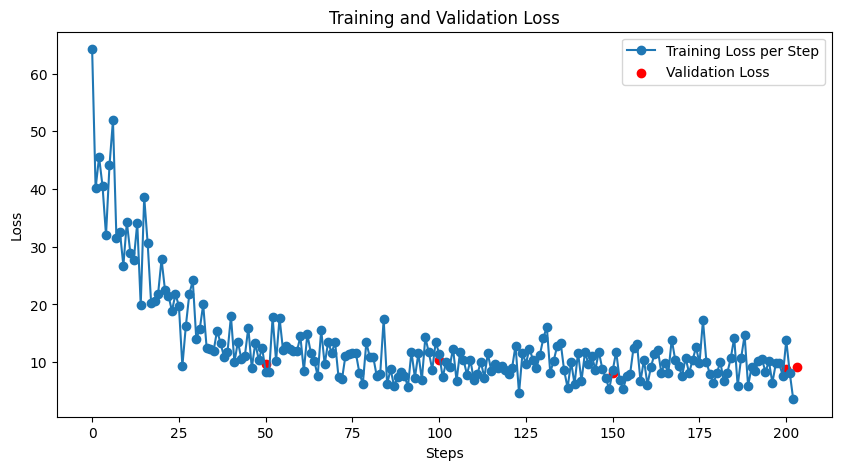

In [15]:
train_loop(model, train_loader, val_loader, optimizer, 1)

## Run a forward pass recursively to predict the weather

In [16]:
import torch
from datetime import datetime, timedelta
import pandas as pd
from meteostat import Point, Daily

# Set the location for Dublin
dublin = Point(53.3498, -6.2603)

# Set the time period to fetch data
end = datetime.today()
start = end - timedelta(days=32)

# Get daily data
data = Daily(dublin, start, end)
data = data.fetch()

# Ensure there are no NaN values
data = data.dropna(subset=['tmax'])

# Get the last 32 days of temperature
last_32_days = data['tmax'].values[-32:]

# Convert to a PyTorch tensor
input_sequence = torch.tensor(last_32_days, dtype=torch.float32).cuda()

# Function to predict the next 7 days of temperature
def predict_next_7_days(model, input_sequence, days=7):
    model.eval()
    predictions = []

    for _ in range(days):
        with torch.no_grad():
            # Forward pass to get the next day's prediction
            output = model(input_sequence.unsqueeze(0).unsqueeze(-1))  # Ensure input is 3D
            next_day_temp = output.item()

            # Append the prediction to the list of predictions
            predictions.append(next_day_temp)

            # Update the input sequence by appending the predicted temperature and removing the oldest one
            input_sequence = torch.cat((input_sequence[1:], torch.tensor([next_day_temp], dtype=torch.float32).cuda()))

    return predictions

# Predict the next 7 days of temperature
predicted_temperatures = predict_next_7_days(model, input_sequence, days=7)

# Print the last 7 temperature data points
print("Last 7 days max temperatures:", [round(temp * 2) / 2 for temp in last_32_days[-7:]])

# Print the predictions
print("Predicted max temperatures for the next 7 days:", [round(temp * 2) / 2 for temp in predicted_temperatures])

Last 7 days max temperatures: [5.5, 5.0, 5.5, 5.5, 10.0, 12.0, 10.5]
Predicted max temperatures for the next 7 days: [10.5, 11.0, 11.0, 11.5, 12.0, 12.5, 13.0]
